In [1]:
%matplotlib inline
%load_ext autoreload
%autoreload 2
import copy
import datetime as dt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats as ss
import warnings
warnings.filterwarnings("ignore")
from python.slider_funcs import slider_plots, process_field_data, read_data
from python.slider_funcs import ensemble_assimilation, slider_plots_func

In [2]:
slider_plots()


Read in simulations


interactive(children=(Dropdown(description='sel_field', options=('7033FUU', '7058CHE', '5002LAB', '7015ALH', '…

In [3]:
(
        parameters,
        t_axis,
        samples,
        lais,
        yields,
        DVS,
        avg_yield,
        df_lai,
        fields,
    ) = read_data()
fields = fields[1:-1]
sel_field = fields[2]

time_lai = df_lai[df_lai.field_code == sel_field][["time"]].values
retval = df_lai[df_lai.field_code == sel_field][["lai_mean", "lai_std"]].values
(obs_lai_mean, obs_lai_std) = retval[:, 0], retval[:, 1]

yield_mean = avg_yield[avg_yield.field_code == sel_field].yield_mean.values
yield_std = avg_yield[avg_yield.field_code == sel_field].yield_std.values


Read in simulations


In [4]:
len(fields[::])
parameters.shape

(14080, 4)

In [5]:
train_fields = fields[::3]
print(len(train_fields))

ll, tt, posterior, sols, sols_sd = ensemble_assimilation(
    parameters,
    np.zeros((yields.shape[0], len(train_fields))),
    t_axis,
    lais,
    yields,
    avg_yield,
    df_lai,
    train_fields,
    sigma_lai=0.3,
    fit_yield=False,
    yield_sigma_scale=0.5,
)

10
16
18
17
19
19
18
18
18
17
18


In [7]:
T =[]
for ii, ff in enumerate(train_fields):
    S =[]
    for b_late in np.arange(0.05, 0.5, 0.05):
        sel_dos, sel_tdwi, sel_beta_early, _ = sols[ii,:]
        diff = np.abs(parameters - np.array([sel_dos, sel_tdwi, sel_beta_early, b_late]))
        ilocs = np.abs(diff).sum(axis=1).argmin()
        obs_yield = avg_yield[avg_yield.field_code == sel_field].yield_mean.values
        yield_std = avg_yield[avg_yield.field_code == sel_field].yield_std.values
        #yield_std = 50
        S.append((yields[ilocs]-obs_yield)**2/(yield_std**2))
    T.append(S)
T=np.array(T).squeeze()
print(T.shape)

(10, 9)


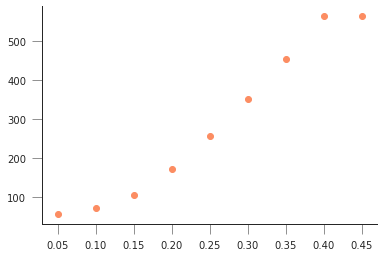

In [8]:
plt.plot(np.arange(0.05, 0.5, 0.05), T.sum(axis=0), 'o')

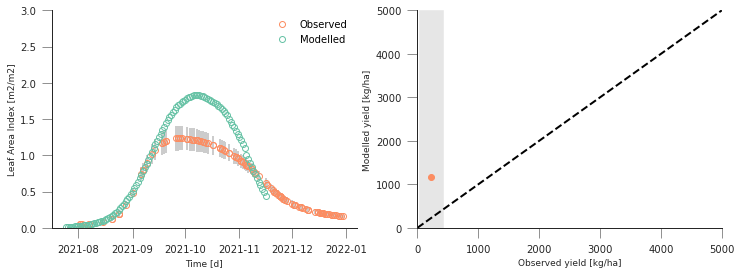

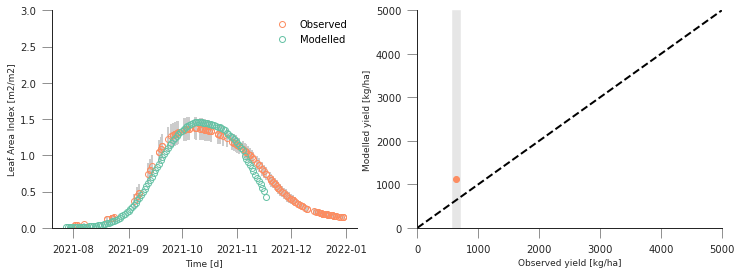

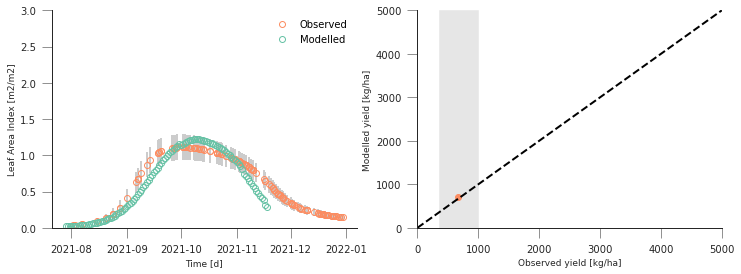

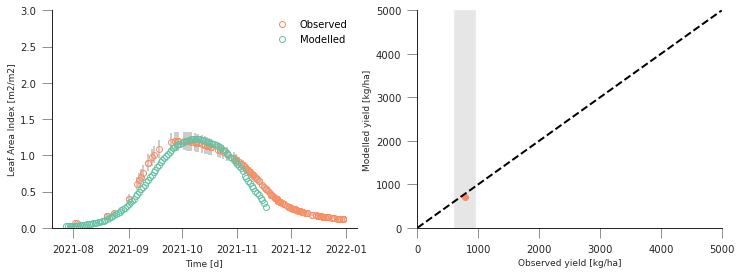

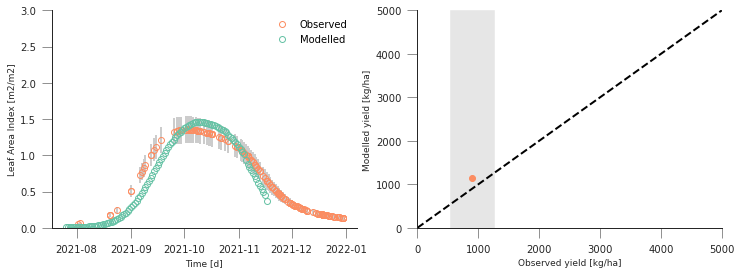

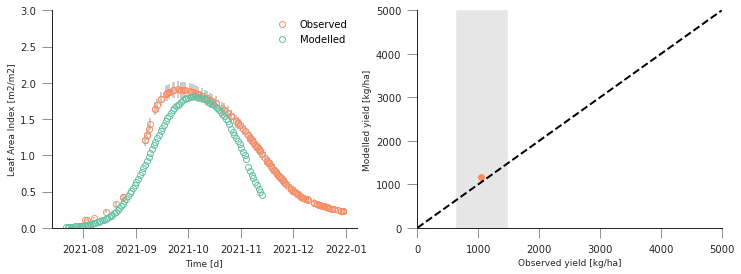

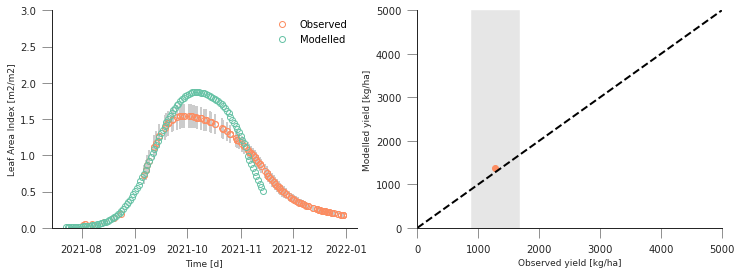

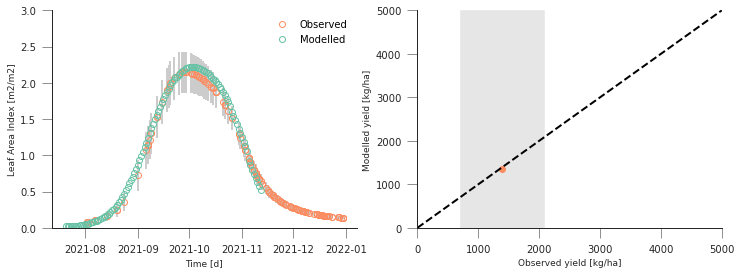

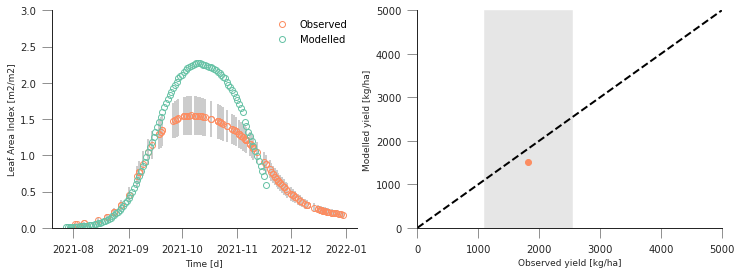

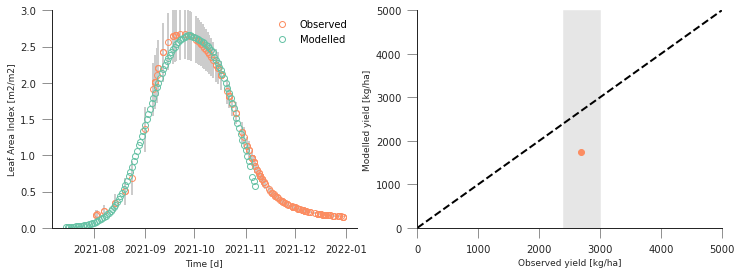

In [9]:
for j, ff in enumerate(train_fields): 
    slider_plots_func(
        ff,
        sols[j, 0],
        sols[j, 1],
        sols[j, 2],
        0.05,
        df_lai,
        avg_yield,
        t_axis,
        lais,
        yields,
        parameters)

LinregressResult(slope=0.3604611913139321, intercept=786.892591054813, rvalue=0.7820467622917477, pvalue=0.007517669545302902, stderr=0.10155984007193321, intercept_stderr=134.32877471010332)


(0.0, 3500.0)

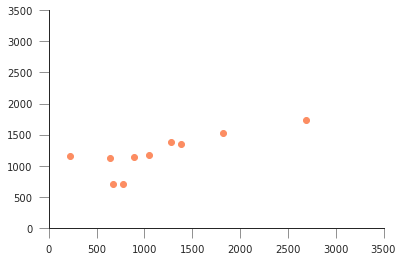

In [10]:
T =[]
Z = []
for ii, ff in enumerate(train_fields):
    sel_dos, sel_tdwi, sel_beta_early, _ = sols[ii,:]
    diff = np.abs(parameters - np.array([sel_dos, sel_tdwi, sel_beta_early, 0.05]))
    ilocs = np.abs(diff).sum(axis=1).argmin()
    obs_yield = avg_yield[avg_yield.field_code == ff].yield_mean.values
    yield_std = avg_yield[avg_yield.field_code == ff].yield_std.values
    #T.append((yields[ilocs]-obs_yield)**2/(yield_std**2))
    T.append(yields[ilocs])
    Z.append(obs_yield)
T=np.array(T).squeeze()

plt.plot(Z, T, 'o')
print(ss.linregress(np.array(Z).squeeze(), T))
plt.xlim(0,3500)
plt.ylim(0,3500)

19
16
18
16
17
16
16
19
18
17
18
18
19
18
19
19
19
18
20


[197.04283242   3.00000006   0.25000646   0.225     ]
[205.14107566  10.50822031   0.31631399   0.225     ]
[210.99999718  18.9987087    0.4          0.225     ]
LinregressResult(slope=0.3239853477250461, intercept=710.4218802618441, rvalue=0.6942517960647931, pvalue=0.0009743019449709216, stderr=0.0814619555842676, intercept_stderr=115.77809419770675)


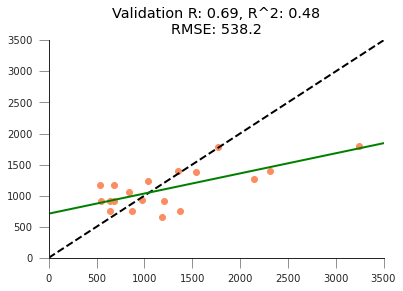

In [11]:
test_fields = [f for f in fields if f not in train_fields]

ll, tt, posterior, sols, sols_sd = ensemble_assimilation(
    parameters,
    np.zeros((yields.shape[0], len(test_fields))),
    t_axis,
    lais,
    yields,
    avg_yield,
    df_lai,
    test_fields,
    sigma_lai=0.1,
    fit_yield=False,
    yield_sigma_scale=0.5,
)
print(sols.min(axis=0))
print(sols.mean(axis=0))
print(sols.max(axis=0))
T =[]
Z = []
for ii, ff in enumerate(test_fields):
    sel_dos, sel_tdwi, sel_beta_early, _ = sols[ii,:]
    diff = np.abs(parameters - np.array([sel_dos, sel_tdwi, sel_beta_early, 0.05]))
    ilocs = np.abs(diff).sum(axis=1).argmin()
    obs_yield = avg_yield[avg_yield.field_code == ff].yield_mean.values
    yield_std = avg_yield[avg_yield.field_code == ff].yield_std.values
    #T.append((yields[ilocs]-obs_yield)**2/(yield_std**2))
    T.append(yields[ilocs])
    Z.append(obs_yield)
T=np.array(T).squeeze()

plt.plot(Z, T, 'o')
print(ss.linregress(np.array(Z).squeeze(), T))
rmse = np.sqrt(np.mean((np.array(Z).squeeze() - T)**2))
plt.xlim(0,3500)
plt.ylim(0,3500)
plt.plot([0,3500], [0,3500], 'k--')
ret = ss.linregress(np.array(Z).squeeze(), T)
plt.plot([0, 3500], np.array([0,3500])*ret.slope + ret.intercept, 'g-')
_=plt.title(f"Validation R:{ret.rvalue:5.2g}, R^2:{ret.rvalue**2:5.2g}\nRMSE:{rmse:6.1f}")

In [12]:
parameters.shape

(14080, 4)

In [13]:
np.exp(-posterior[:,0]).sum()

1.0364539168240707e-19

In [14]:
test_fields = [f for f in fields if f not in sel_fields]

ll, tt, posterior, sols, sols_sd = ensemble_assimilation(
    parameters,
    np.zeros((yields.shape[0], len(test_fields))),
    t_axis,
    lais,
    yields,
    avg_yield,
    df_lai,
    test_fields,
    sigma_lai=0.3,
    fit_yield=False,
    yield_sigma_scale=0.5,
)

T =[]
Z = []
for ii, ff in enumerate(test_fields):
    sel_dos, sel_tdwi, sel_beta_early, _ = sols[ii,:]
    diff = np.abs(parameters - np.array([sel_dos, sel_tdwi, sel_beta_early, 0.5]))
    ilocs = np.abs(diff).sum(axis=1).argmin()
    obs_yield = avg_yield[avg_yield.field_code == ff].yield_mean.values
    yield_std = avg_yield[avg_yield.field_code == ff].yield_std.values
    #T.append((yields[ilocs]-obs_yield)**2/(yield_std**2))
    T.append(yields[ilocs])
    Z.append(obs_yield)
T=np.array(T).squeeze()

plt.plot(Z, T, 'o')
print(ss.linregress(np.array(Z).squeeze(), T))
plt.xlim(0,3500)
plt.ylim(0,3500)
plt.plot([0,3500], [0,3500], 'k--')
ret = ss.linregress(np.array(Z).squeeze(), T)
plt.plot([0, 3500], np.array([0,3500])*ret.slope + ret.intercept, 'g-')
rmse = np.sqrt(np.mean((np.array(Z).squeeze() - T)**2))
_=plt.title(f"Validation R:{ret.rvalue:5.2g}, R^2:{ret.rvalue**2:5.2g}\nRMSE:{rmse:6.1f}")

NameError: name 'sel_fields' is not defined

In [21]:
floc = test_fields.index("")
np.c_[test_fields, Z, sols[:,0], sols[:,1], sols[:,2]]


array([['5002LAB', '541.4333333333333', '199.80365201805427',
        '4.999999899725392', '0.35000000250937535'],
       ['7015ALH', '550.9666666666667', '210.99999718112088',
        '9.77887259355367', '0.2951320392564744'],
       ['7015SAM', '638.1999999999999', '209.97944341851382',
        '18.989201971336108', '0.25005389635101577'],
       ['7018ALH', '638.5666666666667', '210.9998260203705',
        '8.983393319044641', '0.30020758351194177'],
       ['1067ZIN', '683.0333333333333', '203.08832509632916',
        '12.110625170820127', '0.3088937389641025'],
       ['7016ALH', '684.6999999999999', '210.9936154262267',
        '9.000000015453484', '0.2999999999227332'],
       ['7059CHE', '839.3333333333334', '204.0040803662459',
        '10.999993840740583', '0.3000000769907378'],
       ['5014LAB', '872.4', '210.0096863896665', '18.99870870464239',
        '0.25000645647608627'],
       ['7016SAM', '971.1999999999999', '204.00000025065196',
        '9.000001248854925', '0.2999